# 2. モデルを構築する方法

`Model`は` Species` と `ReactionRule` のセットで構成されます。

- `Species` はモデル中の分子エンティティ（例えば、タンパク質のタイプまたは状態）を表します。また `Species` にはサイズなどの属性もあります。
- `ReactionRule` は `Species` 間のインタラクションを表します。(例えば結合や乖離など。)


In [1]:
%matplotlib inline
from ecell4 import *
from ecell4_base.core import *

## 2.1. Species

`Species`はその名前を与えることで生成することができます

In [2]:
sp1 = Species("A")
print(sp1.serial())

A


`Species`の名前にはいくつかの命名規則があります。
この命名規約では特殊記号（例：括弧 `（）`、ドット `.`、アンダーバー` _`）、数字と空白の使用に注意する必要があります。
`Species`には、その属性を扱うための一連のAPIがあります。


In [3]:
sp1.set_attribute("radius", 0.005)
sp1.set_attribute("D", 1)
sp1.set_attribute("location", "cytoplasm")
print(sp1.has_attribute("radius"))
print(sp1.get_attribute("radius").magnitude)
print(sp1.get_attribute("radius").units)
print(sp1.has_attribute("location"))
print(sp1.get_attribute("location"))
sp1.remove_attribute("radius")
print(sp1.has_attribute("radius"))

True
0.005

True
cytoplasm
False


`set_attribute`の引数は、属性の名前とその値です。 属性の名前は文字列でなければなりません。属性値は、文字列、数値、真偽値のいずれかです。`get_attribute`は属性値を返します。ただし、数値の属性値は常に`Quantity`で戻ります。`Quantity`は値(`magnitude`)と単位(`units`)の組です。
`radius`、`D`（拡散係数）、`location`は頻繁に使われるので、一度に設定するためのショートカットがあります。

In [4]:
sp1 = Species("A", 0.005, 1, "cytoplasm")  # serial, radius, D, location

`Species` が同じものかどうかはそれらの `serial` に基づいて評価されます。

In [5]:
print(Species("A") == Species("B"), Species("A") == Species("A"))

False True


`Species`は、1つ以上の `UnitSpecies`から成ります。

In [6]:
sp1 = Species()
usp1 = UnitSpecies("C")
print(usp1.serial())
sp1.add_unit(usp1)
sp1.add_unit(UnitSpecies("A"))
sp1.add_unit(UnitSpecies("B"))
print(sp1.serial(), len(sp1.units()))

C
C.A.B 3


`Species`は、`serial`から複製することができます。
`serial`では、`UnitSpecies`のすべての連番が区切り文字「。」で結合されます。
`UnitSpecies`の順序は`Species`の比較時に影響してきます。


In [7]:
sp1 = Species("C.A.B")
print(sp1.serial())
print(Species("A.B.C") == Species("C.A.B"))
print(Species("A.B.C") == Species("A.B.C"))

C.A.B
False
True


`UnitSpecies`はサイトを持つことができます。
サイトは `name`、`state`、 `bond`からなり、` UnitSpecies`で自動的にソートされます。
`name`は` UnitSpecies`で一意でなければなりません。
すべての値は文字列でなければなりません。
括弧、ドット、空白は含めず、 `bond`以外の数字から始めることはできません。


In [8]:
usp1 = UnitSpecies("A")
usp1.add_site("us", "u", "")
usp1.add_site("ps", "p", "_")
usp1.add_site("bs", "", "_")
print(usp1.serial())

A(bs^_,ps=p^_,us=u)


`UnitSpecies` can be also reproduced from its serial. Please be careful with the order of sites where a site with a state must be placed after sites with no state specification:

In [9]:
usp1 = UnitSpecies()
usp1.deserialize("A(bs^_, us=u, ps=p^_)")
print(usp1.serial())

A(bs^_,ps=p^_,us=u)


Of course, a site of `UnitSpecies` is available even in `Species`' serial.

In [10]:
sp1 = Species("A(bs^1, ps=u).A(bs, ps=p^1)")
print(sp1.serial())
print(len(sp1.units()))

A(bs^1, ps=u).A(bs, ps=p^1)
2


The information (`UnitSpecies` and its `site`) is used for rule-based modeling. The way of rule-based modeling in E-Cell4 will be explained in **7. Introduction of Rule-based Modeling** [local ipynb](tutorial7.ipynb) [readthedocs](http://ecell4.readthedocs.io/en/latest/tutorials/tutorial7.html).

## 2.2. ReactionRule

`ReactionRule` は `reactants`、 `products`と` k`で構成されます。
`reactants`と` products`は `Species`のリストで、` k`は浮動小数点として与えられた反応速度です。


In [11]:
rr1 = ReactionRule()
rr1.add_reactant(Species("A"))
rr1.add_reactant(Species("B"))
rr1.add_product(Species("C"))
rr1.set_k(1.0)

これは、AとBからCへの結合反応になります。
この反応定義では、`Species`に属性を設定する必要はありません。
上記の一連の操作はユーティリティ関数を使うと一行で記述できます。
`ReactionRule`を検査するためには` as_string`関数が利用できます：


In [12]:
rr1 = create_binding_reaction_rule(Species("A"), Species("B"), Species("C"), 1.0)
print(rr1.as_string())

A+B>C|1


You can also provide components to the constructor:

In [13]:
rr1 = ReactionRule([Species("A"), Species("B")], [Species("C")], 1.0)
print(rr1.as_string())

A+B>C|1


基本的に`ReactionRule`はレート`k`を用いた質量作用反応を表します。

`ode` solver also supports rate laws thought it's under development yet.

`ode.ODERatelaw` is explained in **6. How to Solve ODEs with Rate Law Functions** [local ipynb](tutorial6.ipynb) [readthedocs](http://ecell4.readthedocs.io/en/latest/tutorials/tutorial6.html).

## 2.3. NetworkModel

いくつかの`Model`コンポーネントを作成する方法を学びました。 次に、これらのコンポーネントを`Model`に登録してみましょう。

In [14]:
sp1 = Species("A", 0.005, 1)
sp2 = Species("B", 0.005, 1)
sp3 = Species("C", 0.01, 0.5)

In [15]:
rr1 = create_binding_reaction_rule(Species("A"), Species("B"), Species("C"), 0.01)
rr2 = create_unbinding_reaction_rule(Species("C"), Species("A"), Species("B"), 0.3)

`Species`と`ReactionRule`は`add_species_attribute`と`add_reaction_rule`で登録できます。


In [16]:
m1 = NetworkModel()
m1.add_species_attribute(sp1)
m1.add_species_attribute(sp2)
m1.add_species_attribute(sp3)
m1.add_reaction_rule(rr1)
m1.add_reaction_rule(rr2)

これで結合と乖離の反応を持つ単純なモデルができました。
`Model`の内容を確認するには `species_attributes`と`reaction_rules`が利用できます。


In [17]:
print([sp.serial() for sp in m1.species_attributes()])
print([rr.as_string() for rr in m1.reaction_rules()])

['A', 'B', 'C']
['A+B>C|0.01', 'C>A+B|0.3']


モデルの種の属性は、空間シミュレーションには不可欠ですが、非空間アルゴリズム（gillespieとode）では必ずしも必要ではありません。 最初にプッシュされた属性は、後でプッシュされる属性よりも優先度が高くなります。 また、モデルの属性に基づいて種を属性付けすることもできます。


`Species`' attributes in `Model` are indispensable for spatial simulations, but not necessarily needed for non-spatial algorithms, i.e. `gillespie` and `ode`. The attribute pushed first has higher priority than one pushed later. You can also attribute a `Species` based on the attributes in a `Model`.

In [18]:
sp1 = Species("A")
print(sp1.has_attribute("radius"))
sp2 = m1.apply_species_attributes(sp1)
print(sp2.has_attribute("radius"))
print(sp2.get_attribute("radius").magnitude)

False
True
0.005


`Species`, ` ReactionRule`, `NetworkModel` に関連するすべての関数は、C++でも同じように利用できます。

run_simulationでこのモデルを解くことができます。1.「E-Cell4シミュレーションの概要」
You can solve this model with `run_simulation` as explained in **1. Brief Tour of E-Cell4 Simulations** [local ipynb](tutorial1.ipynb) [readthedocs](http://ecell4.readthedocs.io/en/latest/tutorials/tutorial1.html) :

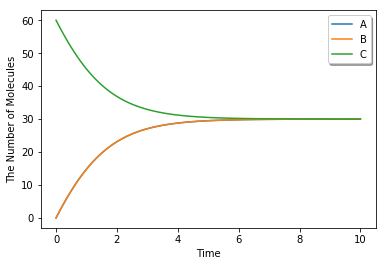

In [19]:
run_simulation(10.0, model=m1, y0={'C': 60})

## 2.4. モデル構築のためのPythonユーティリティ

**1. E-Cell4を用いたシミュレーションの概要** [local ipynb](tutorial1.ipynb) [readthedocs](http://ecell4.readthedocs.io/en/latest/tutorials/tutorial1.html) で示したように, E-Cell4 は `with` ステートメントを用いた簡単なモデルの構築方法を提供しています。

In [20]:
with species_attributes():
    A | B | {'radius': 0.005, 'D': 1}
    C | {'radius': 0.01, 'D': 0.5}

with reaction_rules():
    A + B == C | (0.01, 0.3)

m1 = get_model()

可逆反応の場合、 `<>`はPython 2では `==`の代わりに利用できますが、Python3では非推奨です。
`with`ステートメントでは、宣言されていない変数は自動的に `Species`とみなされます。
Pythonの変数、関数、および文は、 `with`ブロックでも使用できます。

In [21]:
from math import log

ka, kd, kf = 0.01, 0.3, 0.1
tau = 10.0

with reaction_rules():
    E0 + S == ES | (ka, kd)

    if tau > 0:
        ES > E1 + P | kf
        E1 > E0 | log(2) / tau
    else:
        ES > E0 + P | kf

m1 = get_model()
del ka, kd, kf, tau

一方、ブロックの外側でも変数が宣言されると、以下のようにその変数を `Species`として使用することはできません：


In [22]:
A = 10

try:
    with reaction_rules():
        A + B == C | (0.01, 0.3)
except Exception as e:
    print(repr(e))

del A

TypeError("Argument 1 must be AnyCallable, ParseObj, InvExp or MulExp. 'int' was given [10].",)


where `A + B == C` exactly means `10 + B == C`.

合成や分解のような `ReactionRule`の左辺や右辺がない場合は、次のように記述したいかもしれません。

```python
with reaction_rules():
    A > | 1.0  # XXX: will raise SyntaxError
    > A | 1.0  # XXX: will raise SyntaxError
```

しかし、これはPythonの `SyntaxError`のために受け入れられません。

このケースを記述するために、特別な演算子、チルダ `〜`が利用可能です。
`〜`は、以下の `Species`の化学量論係数をゼロに設定します。
つまり、` Species`は `ReactionRule`で無視されます。

In [23]:
with reaction_rules():
    ~A > A | 2.0  # equivalent to `create_synthesis_reaction_rule`
    A > ~A | 1.0  # equivalent to `create_degradation_reaction_rule`

m1 = get_model()
print([rr.as_string() for rr in m1.reaction_rules()])

['>A|2', 'A>|1']


The following `Species`' name is not necessarily needed to be the same as others. The model above describes $[A]'=2-[A]$:

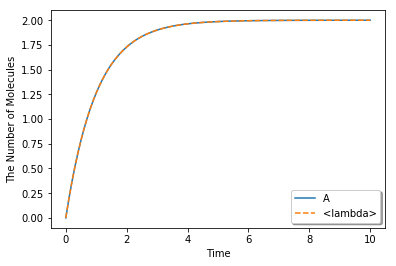

In [24]:
from math import exp
run_simulation(10.0, model=m1, opt_args=['-', lambda t: 2.0 * (1 - exp(-t)), '--'])

一連の反応は1行で記述することができます。
行を2つ以上の物理行に分割するには、括弧で囲みます。

In [25]:
with reaction_rules():
    (E + S == ES | (0.5, 1.0)
         > E + P | 1.5)

m1 = get_model()
print([rr.as_string() for rr in m1.reaction_rules()])

['E+S>ES|0.5', 'ES>E+S|1', 'ES>E+P|1.5']


The method uses global variables in `ecell4.util.decorator` (e.g. `REACTION_RULES`) to cache objects created in the `with` statement:

In [26]:
import ecell4.util.decorator

with reaction_rules():
    A + B == C | (0.01, 0.3)

print(ecell4.util.decorator.REACTION_RULES)  #XXX: Only for debugging
get_model()
print(ecell4.util.decorator.REACTION_RULES)  #XXX: Only for debugging

[<ecell4_base.core.ReactionRule object at 0x1497803eaaf8>, <ecell4_base.core.ReactionRule object at 0x1497803eaa98>]
[]


Modelを構築する際のモジュール性のために、デコレータ関数も便利です。
Pythonのデコレータ関数も利用できます。 デコレータ関数は、モデルのモジュール性を高めます。

In [27]:
@species_attributes
def attrgen1(radius, D):
    A | B | {'radius': radius, 'D': D}
    C | {'radius': radius * 2, 'D': D * 0.5}

@reaction_rules
def rrgen1(kon, koff):
    A + B == C | (kon, koff)

attrs1 = attrgen1(0.005, 1)
rrs1 = rrgen1(0.01, 0.3)
print(attrs1)
print(rrs1)

[<ecell4_base.core.Species object at 0x1497803eaaf8>, <ecell4_base.core.Species object at 0x1497803eab28>, <ecell4_base.core.Species object at 0x1497803eaa98>]
[<ecell4_base.core.ReactionRule object at 0x1497803eab40>, <ecell4_base.core.ReactionRule object at 0x1497803eab58>]


`with`ステートメントの場合とは対照的で、ここではデコレータの後に括弧を追加**しないで**ください。
`reaction_rules`と`species_attributes`でデコレートされた関数はそれぞれ`ReactionRules`と`Species`のリストを返します。
`add_reaction_rules`と`add_species_attributes`を使用して、リストを`Model`に一度に登録できます。


In [28]:
m1 = NetworkModel()
m1.add_species_attributes(attrs1)
m1.add_reaction_rules(rrs1)
print(m1.num_reaction_rules())

2


This method is modular and reusable relative to the way using `with` statement.